In [3]:
import numpy as np
import pandas as pd
import xarray as xr
from rasterio.enums import Resampling

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    warnings.filterwarnings("ignore", message="An input array is constant")
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [8]:
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
our_dss = {fp.stem: xr.open_dataset(fp).rio.write_crs('EPSG:4326') for fp in in_dir.glob('*.nc')}

in_dir = Path('~/scratch/spicy/SnowEx-Hans-s1').expanduser()
han_dss = {fp.stem: xr.open_dataset(fp).rio.write_crs('EPSG:4326') for fp in in_dir.glob('*.nc')}

In [93]:
res= pd.DataFrame()

for k, ds in our_dss.items():
    if k == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    han = han_dss[k]['snd']
    s1 = ds['s1']
    ds['VV'] = ds['s1'].sel(band= 'VV')
    ds['VH'] = ds['s1'].sel(band= 'VH')
    ds['inc'] = ds['s1'].sel(band= 'inc')
    ds = ds.drop(['s1'])
    ds=ds.drop_dims('band')
    ds = ds.transpose('time', 'y', 'x').interpolate_na('x', limit = 10).rio.reproject_match(han, resampling = Resampling.bilinear)
    ds['s1'] = xr.zeros_like(s1)
    ds['s1'].loc[{'band': 'VV'}] = ds['VV']
    ds['s1'].loc[{'band': 'VH'}] = ds['VH']
    ds['s1'].loc[{'band': 'inc'}] = ds['inc']

    ds = retrieval_from_parameters(ds, A=2.5, B =0.5, C = 0.44)

    rs = []
    for ts in ds.time:
        try:
            r, _,_,_ = get_stats(ds['snow_depth'].sel(time = ts), han.sel(time = ts, method = 'nearest', tolerance = '1 days'))
            rs.append(r)
        except KeyError:
            continue
    res.loc[k, 'spicy-hans-r']= np.nanmean(rs)

    res.loc[k, 'hans-lidar-r'] = get_stats(ds['lidar-sd'].transpose('y', 'x').rio.reproject_match(han, resampling = Resampling.average), han.sel(time = im_date,method ='nearest'))[0]
    res.loc[k, 'spicy-lidar-r'] = get_stats(ds['lidar-sd'], ds['snow_depth'].sel(time = im_date,method ='nearest'))[0]

/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/rioxarray/raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/rioxarray/raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/rioxarray/raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/rioxarray/raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.402823466385288

In [94]:
res

,spicy-hans-r,hans-lidar-r,spicy-lidar-r
Mores_2020-02-09,0.497064,0.459825,-0.221844
Frasier_2021-03-19,0.547481,-0.303795,-0.307896
Dry_Creek_2020-02-19,0.542939,0.560635,0.521726
Banner_2021-03-15,0.608957,0.396097,0.388061
Little_Cottonwood_2021-03-18,0.700474,0.845571,0.878706
Mores_2021-03-15,0.685893,0.699896,0.692240
Banner_2020-02-18,0.609704,0.575376,0.510900
Frasier_2020-02-11,0.542886,0.346974,0.298186
Cameron_2021-03-19,0.553828,0.049736,-0.180388


In [98]:
ds = our_dss['Little_Cottonwood_2021-03-18']
han = han_dss['Little_Cottonwood_2021-03-18']
s1 = ds['s1']

ds['VV'] = ds['s1'].sel(band= 'VV')
ds['VH'] = ds['s1'].sel(band= 'VH')
ds['inc'] = ds['s1'].sel(band= 'inc')
ds = ds.drop(['s1'])
ds=ds.drop_dims('band')
ds = ds.transpose('time', 'y', 'x').interpolate_na('x', limit = 10).rio.reproject_match(han, resampling = Resampling.bilinear)
ds['s1'] = xr.zeros_like(s1)
ds['s1'].loc[{'band': 'VV'}] = ds['VV']
ds['s1'].loc[{'band': 'VH'}] = ds['VH']
ds['s1'].loc[{'band': 'inc'}] = ds['inc']

ds = retrieval_from_parameters(ds, A=2.5, B =0.5, C = 0.44)

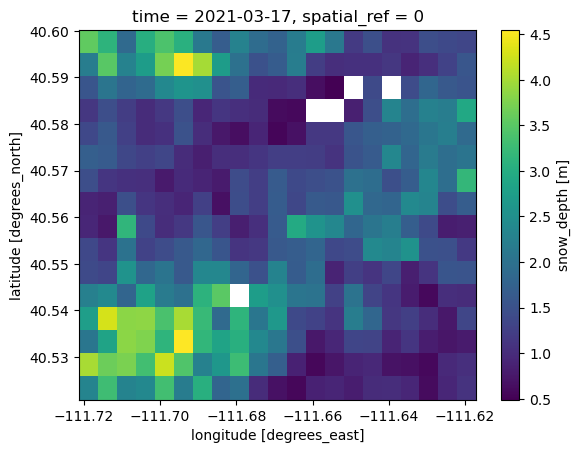

In [102]:
han['snd'].sel(time='2021-03-18', method ='nearest').plot()

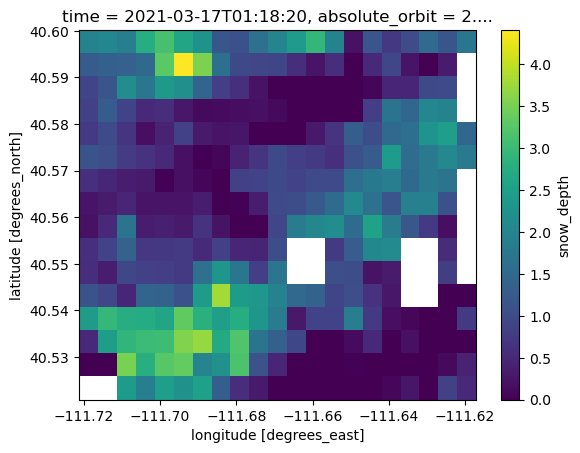

In [99]:
ds['snow_depth'].sel(time='2021-03-18', method ='nearest').plot()